# multi-class classification examples

Author: Optimox, eduardocarvp, Hartorn, queraq

Article from [github.com/dreamquark-ai/tabnet/](https://github.com/dreamquark-ai/tabnet/blob/develop/forest_example.ipynb).

> Note: In this notebook, I am studying the article mentioned above. Some changes may have been made to the code during its implementation.

# Library

In [1]:
from pytorch_tabnet.tab_model import TabNetClassifier

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
np.random.seed(0)


import os
import wget
from pathlib import Path
import shutil
import gzip

from matplotlib import pyplot as plt
%matplotlib inline

# Download ForestCoverType dataset

In [5]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz"
dataset_name = 'forest-cover-type'
tmp_out = Path('./datasets/'+dataset_name+'.gz')
out = Path(os.getcwd()+'/datasets/'+dataset_name+'.csv')

In [6]:
out.parent.mkdir(parents=True, exist_ok=True)
if out.exists():
    print("File already exists.")
else:
    print("Downloading file...")
    wget.download(url, tmp_out.as_posix())
    with gzip.open(tmp_out, 'rb') as f_in:
        with open(out, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

# Load data and split
Same split as in original paper

In [7]:
target = "Covertype"

bool_columns = [
    "Wilderness_Area1", "Wilderness_Area2", "Wilderness_Area3",
    "Wilderness_Area4", "Soil_Type1", "Soil_Type2", "Soil_Type3", "Soil_Type4",
    "Soil_Type5", "Soil_Type6", "Soil_Type7", "Soil_Type8", "Soil_Type9",
    "Soil_Type10", "Soil_Type11", "Soil_Type12", "Soil_Type13", "Soil_Type14",
    "Soil_Type15", "Soil_Type16", "Soil_Type17", "Soil_Type18", "Soil_Type19",
    "Soil_Type20", "Soil_Type21", "Soil_Type22", "Soil_Type23", "Soil_Type24",
    "Soil_Type25", "Soil_Type26", "Soil_Type27", "Soil_Type28", "Soil_Type29",
    "Soil_Type30", "Soil_Type31", "Soil_Type32", "Soil_Type33", "Soil_Type34",
    "Soil_Type35", "Soil_Type36", "Soil_Type37", "Soil_Type38", "Soil_Type39",
    "Soil_Type40"
]

int_columns = [
    "Elevation", "Aspect", "Slope", "Horizontal_Distance_To_Hydrology",
    "Vertical_Distance_To_Hydrology", "Horizontal_Distance_To_Roadways",
    "Hillshade_9am", "Hillshade_Noon", "Hillshade_3pm",
    "Horizontal_Distance_To_Fire_Points"
]

feature_columns = (
    int_columns + bool_columns + [target])


In [8]:
train = pd.read_csv(out, header=None, names=feature_columns)

n_total = len(train)

# Train, val and test split follows
# Rory Mitchell, Andrey Adinets, Thejaswi Rao, and Eibe Frank.
# Xgboost: Scalable GPU accelerated learning. arXiv:1806.11248, 2018.

train_val_indices, test_indices = train_test_split(
    range(n_total), test_size=0.2, random_state=0)
train_indices, valid_indices = train_test_split(
    train_val_indices, test_size=0.2 / 0.6, random_state=0)


In [16]:
for column in train.columns:
    print('Column: {} {}'.format(column, len(train[column].value_counts())))

Column: Elevation 1978
Column: Aspect 361
Column: Slope 67
Column: Horizontal_Distance_To_Hydrology 551
Column: Vertical_Distance_To_Hydrology 700
Column: Horizontal_Distance_To_Roadways 5785
Column: Hillshade_9am 207
Column: Hillshade_Noon 185
Column: Hillshade_3pm 255
Column: Horizontal_Distance_To_Fire_Points 5827
Column: Wilderness_Area1 2
Column: Wilderness_Area2 2
Column: Wilderness_Area3 2
Column: Wilderness_Area4 2
Column: Soil_Type1 2
Column: Soil_Type2 2
Column: Soil_Type3 2
Column: Soil_Type4 2
Column: Soil_Type5 2
Column: Soil_Type6 2
Column: Soil_Type7 2
Column: Soil_Type8 2
Column: Soil_Type9 2
Column: Soil_Type10 2
Column: Soil_Type11 2
Column: Soil_Type12 2
Column: Soil_Type13 2
Column: Soil_Type14 2
Column: Soil_Type15 2
Column: Soil_Type16 2
Column: Soil_Type17 2
Column: Soil_Type18 2
Column: Soil_Type19 2
Column: Soil_Type20 2
Column: Soil_Type21 2
Column: Soil_Type22 2
Column: Soil_Type23 2
Column: Soil_Type24 2
Column: Soil_Type25 2
Column: Soil_Type26 2
Column: So

In [18]:
train['Aspect'] = train['Aspect'].astype('object')

In [19]:
train.dtypes

Elevation                              int64
Aspect                                object
Slope                                  int64
Horizontal_Distance_To_Hydrology       int64
Vertical_Distance_To_Hydrology         int64
Horizontal_Distance_To_Roadways        int64
Hillshade_9am                          int64
Hillshade_Noon                         int64
Hillshade_3pm                          int64
Horizontal_Distance_To_Fire_Points     int64
Wilderness_Area1                       int64
Wilderness_Area2                       int64
Wilderness_Area3                       int64
Wilderness_Area4                       int64
Soil_Type1                             int64
Soil_Type2                             int64
Soil_Type3                             int64
Soil_Type4                             int64
Soil_Type5                             int64
Soil_Type6                             int64
Soil_Type7                             int64
Soil_Type8                             int64
Soil_Type9

# Simple preprocessing

Label encode categorical features and fill empty cells.

In [20]:
categorical_columns = []
categorical_dims =  {}
for col in train.columns[train.dtypes == object]:
    print(col, train[col].nunique())
    l_enc = LabelEncoder()
    train[col] = train[col].fillna("VV_likely")
    train[col] = l_enc.fit_transform(train[col].values)
    categorical_columns.append(col)
    categorical_dims[col] = len(l_enc.classes_)

for col in train.columns[train.dtypes == 'float64']:
    train.fillna(train.loc[train_indices, col].mean(), inplace=True)

Aspect 361


# Define categorical features for categorical embeddings

In [21]:
# This is a generic pipeline but actually no categorical features are available for this dataset

unused_feat = []

features = [ col for col in train.columns if col not in unused_feat+[target]] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]


# Network parameters

In [23]:
clf = TabNetClassifier(
    n_d=64, n_a=64, n_steps=5,
    gamma=1.5, n_independent=2, n_shared=2,
    cat_idxs=cat_idxs,
    cat_dims=cat_dims,
    cat_emb_dim=1,
    lambda_sparse=1e-4, momentum=0.3, clip_value=2.,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params = {"gamma": 0.95,
                     "step_size": 20},
    scheduler_fn=torch.optim.lr_scheduler.StepLR, epsilon=1e-15,
    device_name = 'cpu'
)

/mnt/Dados/Mestrado_Computacao_Aplicada_UFMS/1_semestre/Inteligencia_Artificial/algoritmos-ia/venv/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


# Training

In [25]:
if os.getenv("CI", False):
# Take only a subsample to run CI
    X_train = train[features].values[train_indices][:1000,:]
    y_train = train[target].values[train_indices][:1000]
else:
    X_train = train[features].values[train_indices]
    y_train = train[target].values[train_indices]

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices]

In [26]:
max_epochs = 100 if not os.getenv("CI", False) else 2

In [28]:
from pytorch_tabnet.augmentations import ClassificationSMOTE
aug = ClassificationSMOTE(p=0.2, device_name='cpu')

clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    max_epochs=max_epochs, patience=100,
    batch_size=16384, virtual_batch_size=256,
    augmentations=aug
)

epoch 0  | loss: 1.45941 | train_accuracy: 0.12166 | valid_accuracy: 0.1199  |  0:01:24s
epoch 1  | loss: 0.79861 | train_accuracy: 0.16611 | valid_accuracy: 0.16433 |  0:02:49s
epoch 2  | loss: 0.74996 | train_accuracy: 0.0868  | valid_accuracy: 0.08586 |  0:04:14s
epoch 3  | loss: 0.72388 | train_accuracy: 0.07055 | valid_accuracy: 0.07038 |  0:05:40s
epoch 4  | loss: 0.70742 | train_accuracy: 0.05873 | valid_accuracy: 0.05937 |  0:07:02s
epoch 5  | loss: 0.69486 | train_accuracy: 0.07645 | valid_accuracy: 0.07683 |  0:08:23s
epoch 6  | loss: 0.68888 | train_accuracy: 0.09424 | valid_accuracy: 0.09373 |  0:09:47s
epoch 7  | loss: 0.68355 | train_accuracy: 0.16203 | valid_accuracy: 0.16111 |  0:11:07s
epoch 8  | loss: 0.6789  | train_accuracy: 0.10396 | valid_accuracy: 0.10281 |  0:12:31s
epoch 9  | loss: 0.67149 | train_accuracy: 0.1623  | valid_accuracy: 0.16306 |  0:13:57s
epoch 10 | loss: 0.67064 | train_accuracy: 0.22825 | valid_accuracy: 0.22944 |  0:15:19s
epoch 11 | loss: 0.65

/mnt/Dados/Mestrado_Computacao_Aplicada_UFMS/1_semestre/Inteligencia_Artificial/algoritmos-ia/venv/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


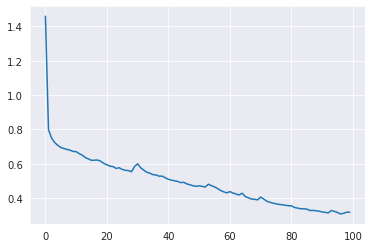

In [29]:
# plot losses
plt.plot(clf.history['loss'])

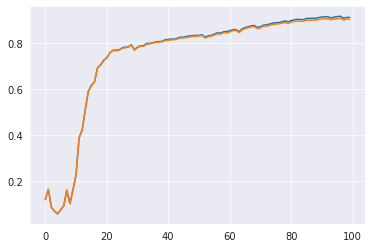

In [30]:
# plot accuracy
plt.plot(clf.history['train_accuracy'])
plt.plot(clf.history['valid_accuracy'])

### Predictions


In [31]:
# To get final results you may need to use a mapping for classes 
# as you are allowed to use targets like ["yes", "no", "maybe", "I don't know"]

preds_mapper = { idx : class_name for idx, class_name in enumerate(clf.classes_)}

preds = clf.predict_proba(X_test)

y_pred = np.vectorize(preds_mapper.get)(np.argmax(preds, axis=1))

test_acc = accuracy_score(y_pred=y_pred, y_true=y_test)

print(f"BEST VALID SCORE FOR {dataset_name} : {clf.best_cost}")
print(f"FINAL TEST SCORE FOR {dataset_name} : {test_acc}")

BEST VALID SCORE FOR forest-cover-type : 0.9083950250747078
FINAL TEST SCORE FOR forest-cover-type : 0.9094773801020628


In [32]:
# or you can simply use the predict method

y_pred = clf.predict(X_test)
test_acc = accuracy_score(y_pred=y_pred, y_true=y_test)
print(f"FINAL TEST SCORE FOR {dataset_name} : {test_acc}")

FINAL TEST SCORE FOR forest-cover-type : 0.9094773801020628


# Save and load Model

In [33]:
# save state dict
saved_filename = clf.save_model('pickle-objects/test_model')

Successfully saved model at pickle-objects/test_model.zip


In [36]:
# define new model and load save parameters
loaded_clf = TabNetClassifier(device_name='cpu')
loaded_clf.load_model(saved_filename)

/mnt/Dados/Mestrado_Computacao_Aplicada_UFMS/1_semestre/Inteligencia_Artificial/algoritmos-ia/venv/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [37]:
loaded_preds = loaded_clf.predict_proba(X_test)
loaded_y_pred = np.vectorize(preds_mapper.get)(np.argmax(loaded_preds, axis=1))

loaded_test_acc = accuracy_score(y_pred=loaded_y_pred, y_true=y_test)

print(f"FINAL TEST SCORE FOR {dataset_name} : {loaded_test_acc}")

FINAL TEST SCORE FOR forest-cover-type : 0.9094773801020628


In [40]:
assert(test_acc == loaded_test_acc)

# Global explainability : feat importance summing to 1

In [41]:
clf.feature_importances_

array([2.01958645e-01, 1.66609746e-03, 3.86429835e-04, 1.90659751e-02,
       9.40442850e-03, 8.66075629e-02, 2.74585758e-03, 2.02519026e-02,
       2.73639393e-02, 8.13729007e-02, 4.87913581e-02, 1.35040171e-02,
       4.46456997e-02, 3.62488361e-04, 4.37539780e-03, 5.35739695e-04,
       1.41431961e-02, 3.60424585e-02, 1.98952435e-02, 4.21030339e-02,
       9.29946567e-03, 1.22204693e-03, 1.40641038e-02, 8.16384052e-03,
       7.17684540e-03, 1.82272706e-02, 7.64529761e-03, 4.10679052e-02,
       1.84712749e-03, 1.57615912e-02, 8.87710330e-04, 1.20906855e-02,
       3.48736949e-03, 9.37498764e-03, 8.05121807e-03, 2.83181297e-02,
       2.36659170e-03, 8.12512970e-03, 5.15354305e-03, 2.09016591e-05,
       2.95132355e-05, 1.95807836e-02, 1.72634042e-03, 1.30144553e-02,
       1.00441246e-03, 1.62063692e-02, 4.11177788e-02, 4.06054195e-03,
       1.17140895e-06, 1.79078918e-03, 4.23540381e-03, 2.87692093e-05,
       8.79516698e-04, 1.87500217e-02])

# Local explainability and masks

In [42]:
explain_matrix, masks = clf.explain(X_test)

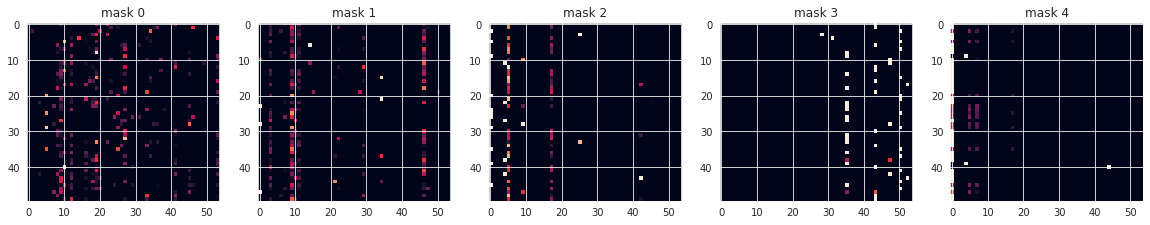

In [43]:
fig, axs = plt.subplots(1, 5, figsize=(20,20))

for i in range(5):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")

# XGB

In [44]:
n_estimators = 1000 if not os.getenv("CI", False) else 20

In [45]:
from xgboost import XGBClassifier

clf_xgb = XGBClassifier(max_depth=8,
    learning_rate=0.1,
    n_estimators=n_estimators,
    verbosity=0,
    silent=None,
    objective="multi:softmax",
    booster='gbtree',
    n_jobs=-1,
    nthread=None,
    gamma=0,
    min_child_weight=1,
    max_delta_step=0,
    subsample=0.7,
    colsample_bytree=1,
    colsample_bylevel=1,
    colsample_bynode=1,
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    base_score=0.5,
    random_state=0,
    seed=None,)

clf_xgb.fit(X_train, y_train,
            eval_set=[(X_valid, y_valid)],
            early_stopping_rounds=40,
            verbose=10)

ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2 3 4 5 6], got [1 2 3 4 5 6 7]

In [ ]:
preds_valid = np.array(clf_xgb.predict_proba(X_valid, ))
valid_acc = accuracy_score(y_pred=np.argmax(preds_valid, axis=1) + 1, y_true=y_valid)
print(valid_acc)

preds_test = np.array(clf_xgb.predict_proba(X_test))
test_acc = accuracy_score(y_pred=np.argmax(preds_test, axis=1) + 1, y_true=y_test)
print(test_acc)